In [227]:
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.ERROR)

GBQ_PROJECT_ID = '620265099307'

sql = """
SELECT
  month,
  pct_id,
  practice,
  total_list_size
FROM
  `hscic.practice_statistics`
WHERE
  month >= '2015-12-01'
AND 
  month < '2018-10-01'

"""
df = pd.read_gbq(sql, GBQ_PROJECT_ID, dialect='standard')


In [228]:
months = df.month.unique()
months.sort()
months = list(months)

In [ ]:
import datetime 
summary = pd.DataFrame()
data = pd.DataFrame()
for m1 in months[:-1]:
    m2 = months[months.index(m1) + 1]
    d1 = df[df.month == m1]
    d2 = df[df.month == m2]
 
    merged = d1.merge(d2, how="left", left_on="practice", right_on="practice")
    merged = merged[['month_x', 'pct_id_x', 'practice', 'total_list_size_x', 'total_list_size_y']]
    merged = merged.rename(columns={'month_x': 'last_open_month', 'pct_id_x': 'pct_id'})
    merged['closed'] = np.isnan(merged['total_list_size_y'])
    conditions = [np.isnan(merged['total_list_size_y']), ~np.isnan(merged['total_list_size_y'])]
    choices = [0 - merged['total_list_size_x'], merged['total_list_size_y'] - merged['total_list_size_x']]
    merged['delta'] = np.select(
        conditions, choices, default=0
    )
    closed = merged[merged['closed'] == True]
    s = pd.DataFrame(
           data={
            'month':m2,
            'closed_count': len(closed),
            'patients_in_closed': closed.total_list_size_x.sum(), 
            'total_change': merged.delta.sum()
           },
    index=[m2])
  
    summary = summary.append(s)
    data = data.append(merged)

In [230]:
data.head(5)

,last_open_month,pct_id,practice,total_list_size_x,total_list_size_y,closed,delta
0,2015-12-01,00C,A83005,11454,11498.0,False,44.0
1,2015-12-01,00C,A83006,7855,7872.0,False,17.0
2,2015-12-01,00C,A83010,14469,14425.0,False,-44.0
3,2015-12-01,00C,A83013,11323,11364.0,False,41.0
4,2015-12-01,00C,A83031,10040,9949.0,False,-91.0


## Summary of closure info per month

* An average of 22 practices are closed per month, affecting an average of 82,000 patients
* An average of 53,000 patients are added to England patient lists per month overall

Note that list sizes were only updated quarterly until April 2017

In [240]:
summary

,month,closed_count,patients_in_closed,total_change
2016-01-01,2016-01-01,41,100925,156213.0
2016-02-01,2016-02-01,0,0,0.0
2016-03-01,2016-03-01,0,0,0.0
2016-04-01,2016-04-01,62,231676,67408.0
2016-05-01,2016-05-01,0,0,0.0
2016-06-01,2016-06-01,0,0,0.0
2016-07-01,2016-07-01,54,187500,120483.0
2016-08-01,2016-08-01,0,0,0.0
2016-09-01,2016-09-01,0,0,0.0
2016-10-01,2016-10-01,5,8047,-108860.0


# Check against an example we've manually checked

In [186]:
closed_jan_2017 = data[(data.closed==True) & (data.last_open_month == '2016-12-01')]

In [187]:
closed_jan_2017.query("pct_id == '08Q'")

,last_open_month,pct_id,practice,total_list_size_x,total_list_size_y,closed,delta
5184,2016-12-01,08Q,G85012,20693,NaN,True,-20693.0
5200,2016-12-01,08Q,G85094,16716,NaN,True,-16716.0
5201,2016-12-01,08Q,G85095,8376,NaN,True,-8376.0


In [202]:
print("The total list size for 08Q changed by {} in Jan 2017".format(
    data[(data.last_open_month == '2016-12-01') & (data.pct_id == '08Q')].delta.sum()))

The total list size for 08Q changed by 3723.0 in Jan 2017


## Can we infer practice list transfers from large closure patient numbers?

Yes, it seems so:

In [264]:
# restrict to when data was monthly
data[(data.last_open_month > '2017-04-01') & (data.closed==True)].sort_values('delta', ascending=True).head()

,last_open_month,pct_id,practice,total_list_size_x,total_list_size_y,closed,delta
790,2017-06-01,01K,P81064,19891,NaN,True,-19891.0
3260,2018-05-01,06N,E82025,17347,NaN,True,-17347.0
3046,2018-08-01,06H,D81063,14167,NaN,True,-14167.0
6433,2018-05-01,15E,M85083,14010,NaN,True,-14010.0
3118,2017-10-01,05X,M82029,13745,NaN,True,-13745.0


In [269]:
# So, taking 01K:
data[(data.last_open_month == '2017-06-01') & (data.pct_id=='01K') & (abs(data.delta) > 800)]

,last_open_month,pct_id,practice,total_list_size_x,total_list_size_y,closed,delta
786,2017-06-01,01K,P81002,33061,51556.0,False,18495.0
790,2017-06-01,01K,P81064,19891,NaN,True,-19891.0
791,2017-06-01,01K,P81085,6709,NaN,True,-6709.0
794,2017-06-01,01K,Y01008,54111,60838.0,False,6727.0


In [271]:
# Or 06N
data[(data.last_open_month == '2018-05-01') & (data.pct_id=='06N') & (abs(data.delta) > 800)]

,last_open_month,pct_id,practice,total_list_size_x,total_list_size_y,closed,delta
3254,2018-05-01,06N,E82013,12245,29532.0,False,17287.0
3260,2018-05-01,06N,E82025,17347,NaN,True,-17347.0


## Investigate the very large net changes in Oct 2017

The summary table above shows more than 100k extra patients added in Oct 2017. How come?

Let's find the CCGs with the most change.

In [241]:
data[(data.last_open_month == '2017-09-01')]\
    .groupby('pct_id')\
    .agg({'delta': 'sum', 'closed': 'sum'})\
    .sort_values('delta')\
    .tail()

,delta,closed
pct_id,,
10Q,5121.0,0.0
14L,6534.0,0.0
03C,7216.0,0.0
04K,9512.0,0.0
03N,9604.0,0.0


So what's going on with 03N?  It had 82 practices both months, with no closures.

The mean list size (7330) increased by 117 patients.  The largest practice had 34,570 patients - an increase of 6855

In [246]:
ccg = data[(data.last_open_month == '2017-09-01') & (data.pct_id == '03N')].sort_values('delta', ascending=False)
ccg.describe()

,total_list_size_x,total_list_size_y,delta
count,82.000000,82.000000,82.000000
mean,7213.634146,7330.756098,117.121951
std,4559.360797,5120.804548,810.472037
min,1199.000000,1196.000000,-60.000000
25%,4447.750000,4435.500000,-12.000000
50%,6617.500000,6624.500000,-2.000000
75%,9223.500000,9244.500000,14.500000
max,27715.000000,34570.000000,6855.000000


The question is where they came from. Only 42 practices had decreasing list sizes, adding up to 628 patients moving elsewhere (or dying):

In [253]:
ccg.head(5)

,last_open_month,pct_id,practice,total_list_size_x,total_list_size_y,closed,delta
1831,2017-09-01,03N,C88627,27715,34570.0,False,6855.0
1760,2017-09-01,03N,C88007,26827,29529.0,False,2702.0
1801,2017-09-01,03N,C88052,8716,8784.0,False,68.0
1790,2017-09-01,03N,C88041,9294,9361.0,False,67.0
1821,2017-09-01,03N,C88085,8629,8673.0,False,44.0


In [252]:
ccg[ccg.delta < 0].delta.sum()

-628.0

We can see that the practice at the top of the list traditionally sheds a few hundred patients a month, but has twice has big increases. It's a University Health Service, so these are new academic years starting.

So the October change is presumably students enrolling, but the place they're coming from not updating their list sizes.

In [256]:
data[data.practice == 'C88627']

,last_open_month,pct_id,practice,total_list_size_x,total_list_size_y,closed,delta
2023,2015-12-01,03N,C88627,30639,29868.0,False,-771.0
2015,2016-01-01,03N,C88627,29868,29868.0,False,0.0
2015,2016-02-01,03N,C88627,29868,29868.0,False,0.0
2015,2016-03-01,03N,C88627,29868,29300.0,False,-568.0
1991,2016-04-01,03N,C88627,29300,29300.0,False,0.0
1991,2016-05-01,03N,C88627,29300,29300.0,False,0.0
1991,2016-06-01,03N,C88627,29300,28205.0,False,-1095.0
1976,2016-07-01,03N,C88627,28205,28205.0,False,0.0
1976,2016-08-01,03N,C88627,28205,28205.0,False,0.0
1976,2016-09-01,03N,C88627,28205,28269.0,False,64.0


# Hypothesis

* When a practice closes, its list size usually goes elsewhere in the same CCG
* If using list size as a denominator, then measure calculations will show zero for those practices
* If aggregating patient-level numbers up to CCG level, then the prescribing assigned to those practices will disappear

Check:

* Large closures are balanced by large list size increases in same CCG (spot check)
* That measures in the main site are calculated at CCG level by summing all numerators and denominators (not aggregating up) - yes
* That the same is true of the RCT analysis - no (see below)

Consequences:
* Not having merger information means sometimes measures will look different until all the prescribing catches up with the list size data

## RCT analysis breakdown

Original code [here](https://github.com/ebmdatalab/low-priority-CCG-visit-RCT/blob/853a43626644feb8dc540b2f60407cdb0fb3ab77/outcomes/Primary%20outcome%20measures%20for%20LPP%20RCT.ipynb).

Numerators (cost) and denominators are taken from CCG-level measures computations, so if measures are right, so are those figures.

Items are taken from tables designated `ebmdatalab.alex.items_*`. These are in turn taken from notebooks related to our Low Priority paper, and [archived in figshare](https://figshare.com/articles/The_NHS_England_low-priority_medicines_initiative_has_had_minimal_impact_on_prescribing/6984296). Specifically, the tables are generated by [this SQL](https://gist.github.com/sebbacon/c7a7f7bdc8c6a25494005c8d5dfd9c3d). This computes a ratio for every numerator/denominator pair at a practice level, *then* groups by CCG - significantly, it [excludes anything with a null ratio](https://gist.github.com/sebbacon/c7a7f7bdc8c6a25494005c8d5dfd9c3d#file-measure-sql-L109-L111). Thus we will lose numerators in the final output.

# Summary 

* September - November each year sees large net list size increases of up to 50,000 more than in other months. This is likely to be university students enrolling and going on their local practice list. These are patients who are either appearing in practice lists for the first time ever, or not also being removed from their previous patient list
* When a practice closes, its list size usually goes elsewhere in the same CCG, and we can see this happening
* RCT analysis for CCG visits currently broken; it will under-report `items` numerators where practices have closed but are still seeing significant prescribing. Closures seem to cluster within CCGs as they are often mergers, so this may have affected our analysis

# Q: How do practice list sizes correlate with total population estimates?

Answer: very well (r=0.99). But interestingly there are consistently about 230,000 more patients on lists than population of England.  This is likely to be a mixture of [ghost patients](http://www.pulsetoday.co.uk/your-practice/practice-topics/practice-income/ghost-patient-drive-comes-back-to-haunt-gps/20007765.article) and a lag due to late reporting after deaths (there are approx 500k per year in the UK).

In [2]:
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.ERROR)

GBQ_PROJECT_ID = '620265099307'


In [46]:
# from https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland

pop = pd.read_csv('MYEB3_summary_components_of_change_series_UK_(2017).csv')
years = range(2001, 2018)
pop = pop[pop.country == 'E'][["population_%s" % y for y in years]]
pop.columns = [str(y) for y in years]
pop = pd.DataFrame(pop.sum())
pop.columns = ["population"]
pop.head(2)

,population
2001,49449746
2002,49679267


In [65]:

sql = """
SELECT
  month,
  sum(total_list_size) as total_list_size
FROM
  `hscic.practice_statistics_all_years`
WHERE %s
GROUP BY month
"""
conditions = []
for y in years:
    conditions.append("month = '%s-06-01'" % y)
sql = sql % " OR ".join(conditions)
df = pd.read_gbq(sql, GBQ_PROJECT_ID, dialect='standard')

In [66]:
df['year'] = df.month.dt.strftime("%Y")
df = df.set_index("year")
merged = df.join(pop)
merged = merged.sort_values("month")
merged['delta'] = merged['total_list_size'] - merged['population']

In [67]:
merged

,month,total_list_size,population,delta
year,,,,
2011,2011-06-01,55267789,53107169,2160620
2012,2012-06-01,55709465,53493729,2215736
2013,2013-06-01,56025327,53865817,2159510
2014,2014-06-01,56455131,54316618,2138513
2015,2015-06-01,57024156,54786327,2237829
2016,2016-06-01,57639650,55268067,2371583
2017,2017-06-01,58437363,55619430,2817933


In [53]:
merged['population'].corr(merged['total_list_size'])

0.9900056356194864

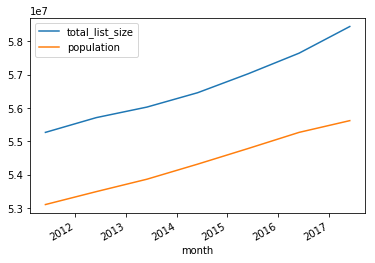

In [56]:
merged.plot.line(x='month')